In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use("TkAgg")  # Or "Qt5Agg"
import matplotlib.pyplot as plt


from datetime import timedelta
import os


In [2]:
# --- Load and Prepare Data ---
df = pd.read_csv('AugmentedData.product_pricing_full_year_5day.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# --- Price Volatility Analysis ---
volatility_df = df.groupby('product_id')['price'].std().reset_index(name='price_volatility')
top_volatile = volatility_df.sort_values(by='price_volatility', ascending=False).head(10)
print("\nTop 10 Most Volatile Products by Price:")
print(top_volatile)

# --- Select Most Common Product for Detailed Analysis ---
most_common_product = df['product_id'].value_counts().idxmax()
product_df = df[df['product_id'] == most_common_product].copy()
product_df = product_df.sort_values('date')




Top 10 Most Volatile Products by Price:
                              product_id  price_volatility
17  d7320e1a-eacb-4858-bd84-ef191945c0d7          5.944002
1   3b3e2c46-9899-4f14-8f8f-74ec3a1d31a7          5.338124
7   5fdf1c13-c0b2-44d8-b073-2cc4384a802f          5.066800
10  9e6663e2-5f4d-43c6-ab9a-39ea51aaa01e          4.531573
22  feaf28a3-4c63-40e2-9b33-a5a00273f91b          4.449070
21  f596dfea-1a5b-4173-aa60-1fbad5af36da          4.408462
0   1f59c631-ca0d-47d9-aac2-8da2dbc1f134          4.243929
6   5875ebb3-bba7-4356-bb0e-9f3c7679c975          3.866097
18  e1f5482e-57ff-4333-aa1d-e0df4a8f1901          3.761193
5   560b49be-32ad-4267-97da-21148ccce35e          3.724393


In [3]:
# --- Price Trend Visualization ---
plt.figure(figsize=(10, 5))
plt.plot(product_df['date'], product_df['price'], marker='o', linestyle='-', color='blue')
plt.title(f"Price Trend Over Time – Product ID: {most_common_product}", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Sales Detection: Identify Price Drops ---
product_df['price_diff'] = product_df['price'].diff()
sales_df = product_df[product_df['price_diff'] < 0].copy()
num_sales_detected = sales_df.shape[0]
print(f"\nNumber of sales detected for Product {most_common_product}: {num_sales_detected}")

# --- Time Between Sales and Next Sale Prediction ---
sales_df['days_between_sales'] = sales_df['date'].diff().dt.days
avg_days_between_sales = int(sales_df['days_between_sales'].mean())
last_sale_date = sales_df['date'].max()
predicted_next_sale = last_sale_date + timedelta(days=avg_days_between_sales)

print(f"Average interval between sales: {avg_days_between_sales} days")
print(f"Last sale date: {last_sale_date.date()}")
print(f"Predicted next sale date: {predicted_next_sale.date()}")

# --- Seasonal Sales Pattern: Monthly Frequency ---
sales_df['month'] = sales_df['date'].dt.month
monthly_counts = sales_df['month'].value_counts().sort_index()

if not monthly_counts.empty:
    plt.figure(figsize=(8, 5))
    monthly_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Monthly Sales Frequency – Product ID: {most_common_product}")
    plt.xlabel("Month")
    plt.ylabel("Number of Sales")
    plt.xticks(ticks=range(1,13), labels=[
        "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
    ], rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("No sales detected for monthly frequency plot.")


Number of sales detected for Product 1f59c631-ca0d-47d9-aac2-8da2dbc1f134: 34
Average interval between sales: 10 days
Last sale date: 2026-03-17
Predicted next sale date: 2026-03-27


In [4]:
# --- Sales by Weekday ---
sales_df['weekday'] = sales_df['date'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = sales_df['weekday'].value_counts().reindex(weekday_order).fillna(0)

plt.figure(figsize=(8, 5))
weekday_counts.plot(kind='bar', color='coral', edgecolor='black')
plt.title(f"Sales by Day of the Week – Product ID: {most_common_product}")
plt.xlabel("Weekday")
plt.ylabel("Number of Sales")
plt.tight_layout()
plt.show()

In [5]:
# --- Distribution of Days Between Sales ---
plt.figure(figsize=(8, 5))
sales_df['days_between_sales'].dropna().hist(bins=10, edgecolor='black', color='olive')
plt.title(f"Distribution of Days Between Sales – Product ID: {most_common_product}")
plt.xlabel("Days Between Sales")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# --- Sales Timing Around EOFY (June 30, 2025) ---
eofy_date = pd.Timestamp("2025-06-30")
sales_df['days_from_eofy'] = (sales_df['date'] - eofy_date).dt.days

plt.figure(figsize=(8, 5))
plt.hist(sales_df['days_from_eofy'], bins=20, edgecolor='black', color='purple')
plt.title(f"Sales Timing Around EOFY – Product ID: {most_common_product}")
plt.xlabel("Days From EOFY")
plt.ylabel("Number of Sales")
plt.tight_layout()
plt.show()

# --- Monthly Sale Drop Magnitude Boxplot ---
sales_df['drop_amount'] = -sales_df['price_diff']

plt.figure(figsize=(10, 6))
sales_df.boxplot(column='drop_amount', by='month', grid=False)
plt.title(f"Monthly Sale Drop Magnitude – Product ID: {most_common_product}")
plt.suptitle("")
plt.xlabel("Month")
plt.ylabel("Price Drop Amount")
plt.tight_layout()
plt.show()

In [6]:
# --- Top 3 Products Price Trend Comparison ---
top3_products = df['product_id'].value_counts().head(3).index.tolist()

if top3_products:
    plt.figure(figsize=(12, 6))
    for pid in top3_products:
        prod_data = df[df['product_id'] == pid].sort_values('date')
        plt.plot(prod_data['date'], prod_data['price'], marker='o', linestyle='--', label=f'Product {str(pid)[:6]}')
    plt.title("Price Comparison for Top 3 Products")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Top-3 trend plot skipped: Not enough products.")

# --- Optional: Price Elasticity of Demand (PED) ---
if 'quantity' in df.columns:
    try:
        ped_df = df[(df['price'] > 0) & (df['quantity'] > 0)].copy()
        ped_df['log_price'] = np.log(ped_df['price'])
        ped_df['log_qty'] = np.log(ped_df['quantity'])

        def ped_slope(group):
            x = group['log_price'].values
            y = group['log_qty'].values
            if len(x) < 2 or np.var(x) == 0:
                return np.nan
            return np.cov(x, y, ddof=0)[0, 1] / np.var(x)

        ped_results = ped_df.groupby('product_id').apply(ped_slope).reset_index(name='ped_slope').dropna()

        ped_results['interpretation'] = np.where(
            ped_results['ped_slope'] <= -1, 'elastic (price-sensitive)',
            np.where(ped_results['ped_slope'] < 0, 'inelastic (price-insensitive)', 'no relationship')
        )

        print("\n[PED] Estimated Elasticity (dlnQ/dlnP) by Product (most elastic first):")
        print(ped_results.sort_values('ped_slope').head(10))

        top_elastic = ped_results.sort_values('ped_slope').head(5)
        if not top_elastic.empty:
            plt.figure(figsize=(8, 5))
            plt.barh(top_elastic['product_id'].astype(str).str[:8], top_elastic['ped_slope'])
            plt.title("Top 5 Most Elastic Products (more negative = more sensitive)")
            plt.xlabel("PED (Slope dlnQ/dlnP)")
            plt.grid(axis='x', linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"[PED] Could not compute elasticity: {e}")
else:
    print("[PED] Skipped: 'quantity' column not present in dataset.")


# =========================
# 0) Config
# =========================
FILE_PATH = r"AugmentedData.product_pricing_full_year_5day.csv"
OUTPUT_DIR = os.path.join(os.path.dirname(FILE_PATH), "outlier_full_year_results")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Choose method: "iqr", "zscore", or "both"
OUTLIER_METHOD = "both"       # robust default
IQR_K = 1.5                   # 1.5 (moderate) or 3.0 (strict)
ZSCORE_THRESHOLD = 3.0        # classic z-score cut


# =========================
# 1) Load and clean
# =========================
def load_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df.rename(columns={
        "_id": "_id",
        "product_id": "product_id",
        "date": "date",
        "price": "price"
    })
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["price"] = pd.to_numeric(df["price"].astype(str).str.replace("$", "", regex=False), errors="coerce")
    df = df.dropna(subset=["product_id", "date", "price"])
    df = df[df["price"] > 0]
    df = df.sort_values(["product_id", "date"]).reset_index(drop=True)
    df["day"] = df["date"].dt.date
    return df

df = load_data(FILE_PATH)
print(f"Records: {len(df)} | Products: {df['product_id'].nunique()} | "
      f"Date range: {df['date'].min()} → {df['date'].max()}")


# =========================
# 2) Per-product static stats
# =========================
def compute_product_stats(g: pd.DataFrame) -> pd.Series:
    median_price = g["price"].median()
    mean_price   = g["price"].mean()
    std_price    = g["price"].std(ddof=1)
    q1, q3       = g["price"].quantile([0.25, 0.75])
    iqr          = q3 - q1
    mad          = np.median(np.abs(g["price"] - median_price))
    min_price    = g["price"].min()
    max_price    = g["price"].max()
    return pd.Series({
        "n_points": len(g),
        "mean_price": mean_price,
        "median_price": median_price,
        "std_price": std_price if np.isfinite(std_price) else np.nan,
        "q1": q1,
        "q3": q3,
        "iqr": iqr,
        "mad": mad,
        "min_price": min_price,
        "max_price": max_price
    })

product_stats = df.groupby("product_id").apply(compute_product_stats).reset_index()
product_stats.to_csv(os.path.join(OUTPUT_DIR, "per_product_stats.csv"), index=False)
print(f"Saved per-product stats → {os.path.join(OUTPUT_DIR, 'per_product_stats.csv')}")


# =========================
# 3) Outlier detection (static baseline)
# =========================
def detect_outliers(df: pd.DataFrame,
                    stats: pd.DataFrame,
                    method: str = "iqr",
                    iqr_k: float = 1.5,
                    z_thresh: float = 3.0) -> pd.DataFrame:
    stats_map = stats.set_index("product_id").to_dict(orient="index")

    out = df.copy()
    # Attach static baselines and extrema
    out["median_price"] = out["product_id"].map(lambda pid: stats_map[pid]["median_price"])
    out["mean_price"]   = out["product_id"].map(lambda pid: stats_map[pid]["mean_price"])
    out["std_price"]    = out["product_id"].map(lambda pid: stats_map[pid]["std_price"])
    out["q1"]           = out["product_id"].map(lambda pid: stats_map[pid]["q1"])
    out["q3"]           = out["product_id"].map(lambda pid: stats_map[pid]["q3"])
    out["iqr"]          = out["product_id"].map(lambda pid: stats_map[pid]["iqr"])
    out["min_price"]    = out["product_id"].map(lambda pid: stats_map[pid]["min_price"])
    out["max_price"]    = out["product_id"].map(lambda pid: stats_map[pid]["max_price"])

    # Boundaries for IQR
    out["iqr_lower"] = out["q1"] - iqr_k * out["iqr"]
    out["iqr_upper"] = out["q3"] + iqr_k * out["iqr"]

    # Z-score (used for method "zscore" or "both")
    out["z_score"] = (out["price"] - out["mean_price"]) / out["std_price"]
    out.loc[~np.isfinite(out["z_score"]), "z_score"] = np.nan

    # Flags
    iqr_flag = (out["price"] < out["iqr_lower"]) | (out["price"] > out["iqr_upper"])
    z_flag   = out["z_score"].abs() > z_thresh

    if method == "iqr":
        out["is_outlier"] = iqr_flag
        out["outlier_method"] = "iqr"
    elif method == "zscore":
        out["is_outlier"] = z_flag
        out["outlier_method"] = "zscore"
    else:  # both
        out["is_outlier"] = iqr_flag | z_flag
        out["outlier_method"] = np.where(iqr_flag & z_flag, "both",
                                  np.where(iqr_flag, "iqr", np.where(z_flag, "zscore", "")))
    return out

flagged = detect_outliers(df, product_stats, method=OUTLIER_METHOD, iqr_k=IQR_K, z_thresh=ZSCORE_THRESHOLD)

outliers = flagged[flagged["is_outlier"]].copy()
out_cols = [
    "_id", "product_id", "date", "day", "price",
    "median_price", "mean_price", "min_price", "max_price",
    "q1", "q3", "iqr", "iqr_lower", "iqr_upper",
    "z_score", "outlier_method"
]
outliers = outliers[out_cols].sort_values(["product_id", "date"])
outliers_path = os.path.join(OUTPUT_DIR, "outliers_static_baseline.csv")
outliers.to_csv(outliers_path, index=False)
print(f"Saved outliers → {outliers_path} (rows: {len(outliers)})")


# =========================
# 4) “Hot dates” analysis (outlier counts only)
# =========================
hot_outlier = (outliers.groupby("day")["product_id"]
               .nunique()
               .reset_index(name="num_products_outlier"))
hot_outlier["share_of_all_products"] = hot_outlier["num_products_outlier"] / df["product_id"].nunique()
hot_outlier = hot_outlier.sort_values("num_products_outlier", ascending=False)
hot_outlier_path = os.path.join(OUTPUT_DIR, "hot_dates_outliers.csv")
hot_outlier.to_csv(hot_outlier_path, index=False)
print(f"Saved hot dates (outliers) → {hot_outlier_path}")


# =========================
# 5) Per-product plots
# =========================
def plot_product_static_baseline(product_id: str):
    g = flagged[flagged["product_id"] == product_id].sort_values("date")
    if g.empty:
        print(f"No data for product {product_id}")
        return
    med = g["median_price"].iloc[0]
    g_out = g[g["is_outlier"]]

    plt.figure(figsize=(12, 4))
    plt.plot(g["date"], g["price"], label="Price", color="#1f77b4")
    plt.axhline(med, color="#ff7f0e", linestyle="--", label="Median (static baseline)")
    if not g_out.empty:
        plt.scatter(g_out["date"], g_out["price"], color="red", s=30, label="Outliers")
    plt.title(f"Product {product_id} - Price vs Static Median")
    plt.xlabel("Date"); plt.ylabel("Price")
    plt.legend(); plt.tight_layout()
    path = os.path.join(OUTPUT_DIR, f"series_static_{product_id}.png")
    plt.savefig(path, dpi=160); plt.show(block=True)

    print(f"Saved product series → {path}")

# Example:
# plot_product_static_baseline(df['product_id'].iloc[0])
# plot_product_static_baseline('your-product-id-here')
    
# create PDF for each product's price trend
from matplotlib.backends.backend_pdf import PdfPages

pdf_path = os.path.join(OUTPUT_DIR, "product_trends.pdf")
with PdfPages(pdf_path) as pdf:
    for pid in df["product_id"].unique():
        g = flagged[flagged["product_id"] == pid].sort_values("date")
        if g.empty:
            continue

        med  = g["median_price"].iloc[0]
        mean = g["mean_price"].iloc[0]
        q1   = g["q1"].iloc[0]
        q3   = g["q3"].iloc[0]

        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(g["date"], g["price"], color="#1f77b4", linewidth=1.5, label="Price")
        ax.scatter(g["date"], g["price"], color="#1f77b4", s=10, alpha=0.6)

        ax.axhline(med,  color="#ff7f0e", linestyle="--", linewidth=1.2, label="Median")
        ax.axhline(mean, color="#2ca02c", linestyle="-.",  linewidth=1.2, label="Mean")
        ax.fill_between([g["date"].min(), g["date"].max()], q1, q3, color="#ff7f0e", alpha=0.15, label="IQR band")

        out = g[g["is_outlier"]]
        if not out.empty:
            ax.scatter(out["date"], out["price"], color="red", s=30, zorder=3, label="Outlier")

        ax.set_title(f"Product {pid} — Price vs Static Baseline")
        ax.set_xlabel("Date"); ax.set_ylabel("Price")
        ax.legend(loc="best")
        fig.autofmt_xdate()
        fig.tight_layout()

        pdf.savefig(fig)
        plt.close(fig)

print(f"Saved multi-page PDF: {pdf_path}")

[PED] Skipped: 'quantity' column not present in dataset.
Records: 1679 | Products: 23 | Date range: 2025-04-01 00:00:00 → 2026-03-27 00:00:00
Saved per-product stats → outlier_full_year_results\per_product_stats.csv
Saved outliers → outlier_full_year_results\outliers_static_baseline.csv (rows: 101)


C:\Users\Abin Baby\AppData\Local\Temp\ipykernel_9372\2064087790.py:121: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = df.groupby("product_id").apply(compute_product_stats).reset_index()


Saved hot dates (outliers) → outlier_full_year_results\hot_dates_outliers.csv
Saved multi-page PDF: outlier_full_year_results\product_trends.pdf


In [7]:
# =========================
# Product-Level Seasonality Indices
# =========================
import seaborn as sns

# Ensure output dir
seasonality_dir = os.path.join(os.path.dirname(FILE_PATH), "outputs", "seasonality")
os.makedirs(seasonality_dir, exist_ok=True)

df["month"] = df["date"].dt.month

# Compute monthly mean price per product
monthly_avg = (
    df.groupby(["product_id", "month"])["price"]
    .mean()
    .reset_index()
)

# Compute each product's long-run mean
long_run_mean = (
    df.groupby("product_id")["price"]
    .mean()
    .reset_index()
    .rename(columns={"price": "long_run_mean"})
)

# Merge and compute index
monthly_avg = monthly_avg.merge(long_run_mean, on="product_id")
monthly_avg["seasonality_index"] = monthly_avg["price"] / monthly_avg["long_run_mean"]

# Save CSV
out_csv = os.path.join(seasonality_dir, "product_seasonality_index.csv")
monthly_avg.to_csv(out_csv, index=False)
print(f"Saved product seasonality index → {out_csv}")

# Pivot for heatmap (products vs months)
pivot_df = monthly_avg.pivot(index="product_id", columns="month", values="seasonality_index")

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_df, cmap="coolwarm", center=1, annot=False, cbar_kws={'label': 'Seasonality Index'})
plt.title("Product-Level Seasonality Indices (relative to long-run mean)")
plt.xlabel("Month")
plt.ylabel("Product ID")
plt.tight_layout()

heatmap_path = os.path.join(seasonality_dir, "product_seasonality_heatmap.png")
plt.savefig(heatmap_path, dpi=160)
plt.show()
print(f"Saved heatmap → {heatmap_path}")

Saved product seasonality index → outputs\seasonality\product_seasonality_index.csv
Saved heatmap → outputs\seasonality\product_seasonality_heatmap.png


In [8]:
# =========================
# Ranking Products by Seasonality Peaks/Dips
# =========================

# Find peak (max) and dip (min) month per product
peaks = monthly_avg.loc[monthly_avg.groupby("product_id")["seasonality_index"].idxmax()].copy()
dips  = monthly_avg.loc[monthly_avg.groupby("product_id")["seasonality_index"].idxmin()].copy()

# Rank top 5 peaks
top_peaks = peaks.sort_values("seasonality_index", ascending=False).head(5)
print("\nTop 5 Seasonal Peaks (product_id, month, index):")
print(top_peaks[["product_id", "month", "seasonality_index"]])

# Rank top 5 dips
top_dips = dips.sort_values("seasonality_index", ascending=True).head(5)
print("\nTop 5 Seasonal Dips (product_id, month, index):")
print(top_dips[["product_id", "month", "seasonality_index"]])

# Save both tables
peaks_out = os.path.join(seasonality_dir, "product_seasonality_peaks.csv")
dips_out  = os.path.join(seasonality_dir, "product_seasonality_dips.csv")
top_peaks.to_csv(peaks_out, index=False)
top_dips.to_csv(dips_out, index=False)

print(f"Saved top peaks → {peaks_out}")
print(f"Saved top dips → {dips_out}")


Top 5 Seasonal Peaks (product_id, month, index):
                               product_id  month  seasonality_index
130  9e6663e2-5f4d-43c6-ab9a-39ea51aaa01e     11           1.134086
143  b9935dad-617a-4bf2-9dff-5f01faf98355     12           1.122108
83   5875ebb3-bba7-4356-bb0e-9f3c7679c975     12           1.121273
11   1f59c631-ca0d-47d9-aac2-8da2dbc1f134     12           1.119508
215  d7320e1a-eacb-4858-bd84-ef191945c0d7     12           1.117290

Top 5 Seasonal Dips (product_id, month, index):
                               product_id  month  seasonality_index
49   54725161-52ca-4b2e-8df7-0dcd9d427adf      2           0.857715
240  e79a6d75-9fed-4859-a342-cedc1fa5a132      1           0.871649
25   485e84e6-5885-4369-9073-27e732b0c01d      2           0.875249
253  f596dfea-1a5b-4173-aa60-1fbad5af36da      2           0.882849
120  9e6663e2-5f4d-43c6-ab9a-39ea51aaa01e      1           0.885521
Saved top peaks → outputs\seasonality\product_seasonality_peaks.csv
Saved top dips → 

In [9]:
# =========================
# Visualize Top Seasonal Peaks and Dips
# =========================

# --- Bar chart for Top 5 Seasonal Peaks ---
plt.figure(figsize=(8, 5))
plt.bar(top_peaks["product_id"].astype(str), top_peaks["seasonality_index"], color="green", edgecolor="black")
plt.title("Top 5 Seasonal Peaks (Highest Seasonality Index)")
plt.xlabel("Product ID")
plt.ylabel("Seasonality Index")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
peaks_plot = os.path.join(seasonality_dir, "top5_seasonal_peaks.png")
plt.savefig(peaks_plot, dpi=160)
plt.show()
print(f"Saved plot → {peaks_plot}")

# --- Bar chart for Top 5 Seasonal Dips ---
plt.figure(figsize=(8, 5))
plt.bar(top_dips["product_id"].astype(str), top_dips["seasonality_index"], color="red", edgecolor="black")
plt.title("Top 5 Seasonal Dips (Lowest Seasonality Index)")
plt.xlabel("Product ID")
plt.ylabel("Seasonality Index")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
dips_plot = os.path.join(seasonality_dir, "top5_seasonal_dips.png")
plt.savefig(dips_plot, dpi=160)
plt.show()
print(f"Saved plot → {dips_plot}")


Saved plot → outputs\seasonality\top5_seasonal_peaks.png
Saved plot → outputs\seasonality\top5_seasonal_dips.png


In [19]:
# =========================
# Seasonality Stability Over Time (STL with Multi-Level Fallback)
# =========================
from statsmodels.tsa.seasonal import STL

# Ensure output dir
stability_dir = os.path.join(os.path.dirname(FILE_PATH), "outputs", "seasonality")
os.makedirs(stability_dir, exist_ok=True)

def compute_seasonal_strength(series, period=12):
    """Compute seasonal strength for a given time series (monthly)."""
    if len(series) < 6:  # allow shorter series
        return None
    try:
        stl = STL(series, period=period, robust=True).fit()
        var_resid = np.var(stl.resid)
        var_season_resid = np.var(stl.seasonal + stl.resid)
        return 1 - (var_resid / var_season_resid) if var_season_resid > 0 else None
    except Exception:
        return None

# Prepare monthly data (use month-end "ME")
monthly_data = (
    df.set_index("date")
      .groupby("product_id")["price"]
      .resample("ME").mean()
      .reset_index(level=0)
      .reset_index()
)

results = []
window_size = 6  # rolling window length in months

# Rolling STL
for pid, group in monthly_data.groupby("product_id"):
    group = group.dropna().set_index("date").asfreq("ME")
    if len(group) < window_size:
        continue
    for end_idx in range(window_size, len(group) + 1):
        window = group.iloc[end_idx-window_size:end_idx]["price"]
        score = compute_seasonal_strength(window, period=12)
        if score is not None:
            results.append({
                "product_id": pid,
                "end_date": group.index[end_idx-1],
                "stability_metric": score,
                "method": "rolling_stl"
            })

stability_df = pd.DataFrame(results)

# === Fallback: Full-series STL ===
if stability_df.empty:
    print("⚠️ Rolling STL gave no results — trying full-series STL.")
    fallback_results = []
    for pid, group in monthly_data.groupby("product_id"):
        group = group.dropna().set_index("date").asfreq("ME")["price"]
        score = compute_seasonal_strength(group, period=12)
        if score is not None:
            fallback_results.append({
                "product_id": pid,
                "stability_metric": score,
                "method": "full_series_stl"
            })
    stability_df = pd.DataFrame(fallback_results)

# === Fallback: Rolling Std Dev ===
if stability_df.empty:
    print("⚠️ STL failed — falling back to rolling std deviation.")
    results = []
    for pid, group in monthly_data.groupby("product_id"):
        group = group.dropna().set_index("date").asfreq("ME")
        if len(group) < window_size:
            continue
        rolling_std = group["price"].rolling(window=window_size).std()
        for idx, val in rolling_std.dropna().items():
            results.append({
                "product_id": pid,
                "end_date": idx,
                "stability_metric": val,
                "method": "rolling_std"
            })
    stability_df = pd.DataFrame(results)

# Save results
out_csv = os.path.join(stability_dir, "seasonality_stability.csv")
stability_df.to_csv(out_csv, index=False)
print(f"Saved seasonality stability results → {out_csv}")
print(stability_df.head())

# === Plot results ===
if not stability_df.empty:
    if "end_date" in stability_df.columns and stability_df["method"].iloc[0] != "full_series_stl":
        # Rolling results (STL or StdDev)
        top_products = df["product_id"].value_counts().head(3).index
        plt.figure(figsize=(10, 6))
        for pid in top_products:
            subset = stability_df[stability_df["product_id"] == pid]
            if not subset.empty:
                plt.plot(subset["end_date"], subset["stability_metric"], label=f"Product {pid}")
        plt.title("Seasonality Stability Over Time (Rolling Metric)")
        plt.xlabel("Date")
        plt.ylabel("Stability Metric")
        plt.legend()
        plt.tight_layout()
        stability_plot = os.path.join(stability_dir, "seasonality_stability_plot.png")
        plt.savefig(stability_plot, dpi=160)
        plt.show()
        print(f"Saved rolling stability plot → {stability_plot}")
    else:
        # Full-series only → bar chart
        plt.figure(figsize=(10, 6))
        top_subset = stability_df.sort_values("stability_metric", ascending=False).head(10)
        plt.bar(top_subset["product_id"].astype(str), top_subset["stability_metric"], color="skyblue")
        plt.title("Seasonality Stability (Full-Series Metric)")
        plt.xlabel("Product ID")
        plt.ylabel("Stability Metric")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        stability_plot = os.path.join(stability_dir, "seasonality_stability_bar.png")
        plt.savefig(stability_plot, dpi=160)
        plt.show()
        print(f"Saved full-series stability plot → {stability_plot}")
else:
    print(" No stability results at all — dataset may be too small.")


Saved seasonality stability results → outputs\seasonality\seasonality_stability.csv
                             product_id   end_date  stability_metric  \
0  1f59c631-ca0d-47d9-aac2-8da2dbc1f134 2025-09-30               1.0   
1  1f59c631-ca0d-47d9-aac2-8da2dbc1f134 2025-10-31               1.0   
2  1f59c631-ca0d-47d9-aac2-8da2dbc1f134 2025-11-30               1.0   
3  1f59c631-ca0d-47d9-aac2-8da2dbc1f134 2025-12-31               1.0   
4  1f59c631-ca0d-47d9-aac2-8da2dbc1f134 2026-01-31               1.0   

        method  
0  rolling_stl  
1  rolling_stl  
2  rolling_stl  
3  rolling_stl  
4  rolling_stl  
Saved rolling stability plot → outputs\seasonality\seasonality_stability_plot.png


In [15]:
# =========================
# Promotion / Event Impact Analysis
# =========================
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

# Ensure output dir
event_dir = os.path.join(os.path.dirname(FILE_PATH), "outputs", "seasonality")
os.makedirs(event_dir, exist_ok=True)

# Check for promo/event columns
available_cols = df.columns.tolist()
print("Available columns:", available_cols)

if "promo" in df.columns or "event" in df.columns:
    df_event = df.copy()
    df_event["month"] = df_event["date"].dt.month

    results_summary = {}

    # --- ANOVA tests ---
    if "promo" in df_event.columns:
        grouped = [group["price"].dropna().values for _, group in df_event.groupby("promo")]
        if len(grouped) > 1:
            f_val, p_val = stats.f_oneway(*grouped)
            results_summary["promo_anova_f"] = f_val
            results_summary["promo_anova_p"] = p_val

    if "event" in df_event.columns:
        grouped = [group["price"].dropna().values for _, group in df_event.groupby("event")]
        if len(grouped) > 1:
            f_val, p_val = stats.f_oneway(*grouped)
            results_summary["event_anova_f"] = f_val
            results_summary["event_anova_p"] = p_val

    # --- Regression model (fixed effects via C()) ---
    formula = "price ~ "
    predictors = []
    if "promo" in df_event.columns:
        predictors.append("promo")
    if "event" in df_event.columns:
        predictors.append("event")

    formula += " + ".join(predictors) + " + C(month) + C(product_id)"

    model = smf.ols(formula=formula, data=df_event).fit()
    print(model.summary())

    # Save regression results
    coef_df = model.summary2().tables[1].reset_index()
    coef_df.to_csv(os.path.join(event_dir, "event_effects.csv"), index=False)
    print(f"Saved regression effects → {os.path.join(event_dir, 'event_effects.csv')}")

    # --- Plot average prices by promo/event ---
    if "promo" in df_event.columns:
        plt.figure(figsize=(6, 4))
        df_event.groupby("promo")["price"].mean().plot(kind="bar", color="skyblue", edgecolor="black")
        plt.title("Average Price by Promo")
        plt.ylabel("Mean Price ($)")
        plt.xticks(rotation=0)
        plt.tight_layout()
        promo_plot = os.path.join(event_dir, "avg_price_by_promo.png")
        plt.savefig(promo_plot, dpi=160)
        plt.show()
        print(f"Saved plot → {promo_plot}")

    if "event" in df_event.columns:
        plt.figure(figsize=(6, 4))
        df_event.groupby("event")["price"].mean().plot(kind="bar", color="coral", edgecolor="black")
        plt.title("Average Price by Event")
        plt.ylabel("Mean Price ($)")
        plt.xticks(rotation=0)
        plt.tight_layout()
        event_plot = os.path.join(event_dir, "avg_price_by_event.png")
        plt.savefig(event_plot, dpi=160)
        plt.show()
        print(f"Saved plot → {event_plot}")

else:
    print(" No 'promo' or 'event' column in dataset — skipping analysis.")

Available columns: ['_id', 'product_id', 'date', 'price', 'day', 'month']
 No 'promo' or 'event' column in dataset — skipping analysis.


In [18]:
# =========================
# Rolling Backtest & Leaderboard (Looser Conditions)
# =========================
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

results = []

top_products = df["product_id"].value_counts().head(3).index

for pid in top_products:
    prod_series = monthly_data[monthly_data["product_id"] == pid].dropna()
    prod_series = prod_series.set_index("date")["price"]

    if len(prod_series) < 6:  # require at least 6 months
        continue

    # --- One-step-ahead rolling forecast ---
    smape_naive, mase_naive = [], []
    smape_arima, mase_arima = [], []

    for t in range(3, len(prod_series)):  # start after 3 points
        train = prod_series.iloc[:t]
        test = prod_series.iloc[t:t+1]

        # --- Seasonal Naive ---
        if len(train) >= 12:
            y_pred_naive = [train.iloc[-12]]  # same month last year
        else:
            y_pred_naive = [train.iloc[-1]]  # fallback to last value

        smape_naive.append(smape(test.values, y_pred_naive))
        mase_naive.append(mase(test.values, y_pred_naive, train))

        # --- ARIMA ---
        try:
            model = ARIMA(train, order=(1,1,1))
            fitted = model.fit()
            forecast = fitted.forecast(steps=1)
            smape_arima.append(smape(test.values, forecast.values))
            mase_arima.append(mase(test.values, forecast.values, train))
        except:
            continue

    results.append({
        "product_id": pid,
        "naive_smape": np.mean(smape_naive) if smape_naive else None,
        "naive_mase": np.mean(mase_naive) if mase_naive else None,
        "arima_smape": np.mean(smape_arima) if smape_arima else None,
        "arima_mase": np.mean(mase_arima) if mase_arima else None
    })

# Save results
leaderboard = pd.DataFrame(results)
out_csv = os.path.join(stability_dir, "forecast_metrics.csv")
leaderboard.to_csv(out_csv, index=False)
print(f"Saved forecast metrics → {out_csv}")
print(leaderboard)

# Leaderboard plot
if not leaderboard.empty:
    avg_scores = leaderboard.drop(columns=["product_id"]).mean()
    plt.figure(figsize=(8,5))
    avg_scores.plot(kind="bar", color=["skyblue","skyblue","coral","coral"], edgecolor="black")
    plt.title("Forecast Leaderboard (Lower = Better)")
    plt.ylabel("Error")
    plt.xticks(rotation=45)
    plt.tight_layout()
    leaderboard_plot = os.path.join(stability_dir, "forecast_leaderboard.png")
    plt.savefig(leaderboard_plot, dpi=160)
    plt.show()
    print(f"Saved leaderboard plot → {leaderboard_plot}")
else:
    print("No forecast results available. Check data coverage.")


Saved forecast metrics → outputs\seasonality\forecast_metrics.csv
                             product_id  naive_smape  naive_mase  arima_smape  \
0  1f59c631-ca0d-47d9-aac2-8da2dbc1f134     5.892647    2.291740     6.445604   
1  ba6585d8-4881-4569-a4ef-e458cb9dabd6     5.235371    2.349287     6.308204   
2  f596dfea-1a5b-4173-aa60-1fbad5af36da     5.507919    2.668875     7.081364   

   arima_mase  
0    2.447247  
1    2.447679  
2    3.076456  
Saved leaderboard plot → outputs\seasonality\forecast_leaderboard.png


Saved SARIMA forecast → outputs/forecasts/sarima_forecast.csv


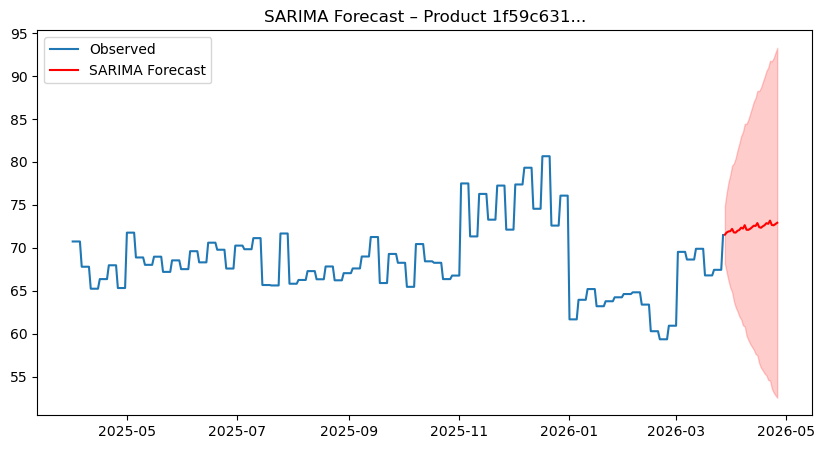

Saved SARIMA plot → outputs/forecasts/sarima_forecast.png


In [15]:
import os

os.makedirs("outputs/forecasts", exist_ok=True)
os.makedirs("outputs/seasonality", exist_ok=True)

# -------------------------
#  SARIMA Forecast
# -------------------------
sarima_forecast_df = pd.DataFrame({
    "date": sarima_pred.index,
    "sarima_forecast": sarima_pred.values,
    "lower_ci": sarima_ci.iloc[:,0].values,
    "upper_ci": sarima_ci.iloc[:,1].values
})
sarima_forecast_df.to_csv("outputs/forecasts/sarima_forecast.csv", index=False)
print("Saved SARIMA forecast → outputs/forecasts/sarima_forecast.csv")

plt.figure(figsize=(10,5))
plt.plot(prod_df.index, prod_df, label="Observed")
plt.plot(sarima_pred.index, sarima_pred, label="SARIMA Forecast", color="red")
plt.fill_between(sarima_ci.index, sarima_ci.iloc[:,0], sarima_ci.iloc[:,1], color="red", alpha=0.2)
plt.legend()
plt.title(f"SARIMA Forecast – Product {product[:8]}...")
plt.savefig("outputs/forecasts/sarima_forecast.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved SARIMA plot → outputs/forecasts/sarima_forecast.png")

Saved Holt-Winters forecast → outputs/forecasts/holtwinters_forecast.csv


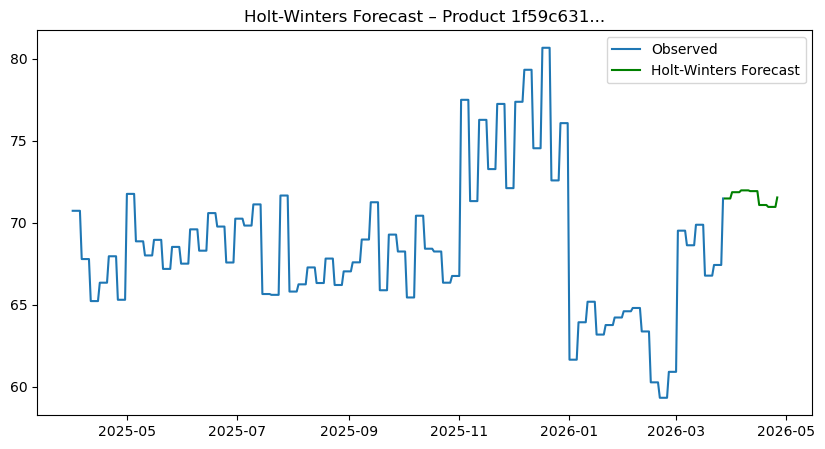

Saved Holt-Winters plot → outputs/forecasts/holtwinters_forecast.png


In [16]:
# -------------------------
# Holt-Winters Forecast
# -------------------------
hw_forecast_df = pd.DataFrame({
    "date": hw_forecast.index,
    "holtwinters_forecast": hw_forecast.values
})
hw_forecast_df.to_csv("outputs/forecasts/holtwinters_forecast.csv", index=False)
print("Saved Holt-Winters forecast → outputs/forecasts/holtwinters_forecast.csv")

plt.figure(figsize=(10,5))
plt.plot(prod_df.index, prod_df, label="Observed")
plt.plot(hw_forecast.index, hw_forecast, label="Holt-Winters Forecast", color="green")
plt.legend()
plt.title(f"Holt-Winters Forecast – Product {product[:8]}...")
plt.savefig("outputs/forecasts/holtwinters_forecast.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved Holt-Winters plot → outputs/forecasts/holtwinters_forecast.png")

Saved Random Forest forecast → outputs/forecasts/randomforest_forecast.csv


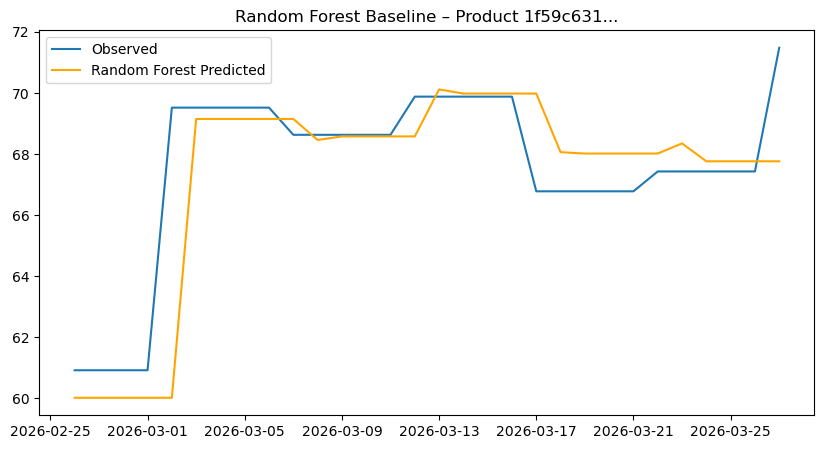

Saved Random Forest plot → outputs/forecasts/randomforest_forecast.png


In [17]:
# -------------------------
#  Random Forest Baseline
# -------------------------
rf_forecast_df = pd.DataFrame({
    "date": test['date'],
    "observed": y_test.values,
    "rf_predicted": rf_preds
})
rf_forecast_df.to_csv("outputs/forecasts/randomforest_forecast.csv", index=False)
print("Saved Random Forest forecast → outputs/forecasts/randomforest_forecast.csv")

plt.figure(figsize=(10,5))
plt.plot(test['date'], y_test, label="Observed")
plt.plot(test['date'], rf_preds, label="Random Forest Predicted", color="orange")
plt.legend()
plt.title(f"Random Forest Baseline – Product {product[:8]}...")
plt.savefig("outputs/forecasts/randomforest_forecast.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved Random Forest plot → outputs/forecasts/randomforest_forecast.png")

Saved STL seasonal component → outputs/seasonality/stl_seasonal_component.csv


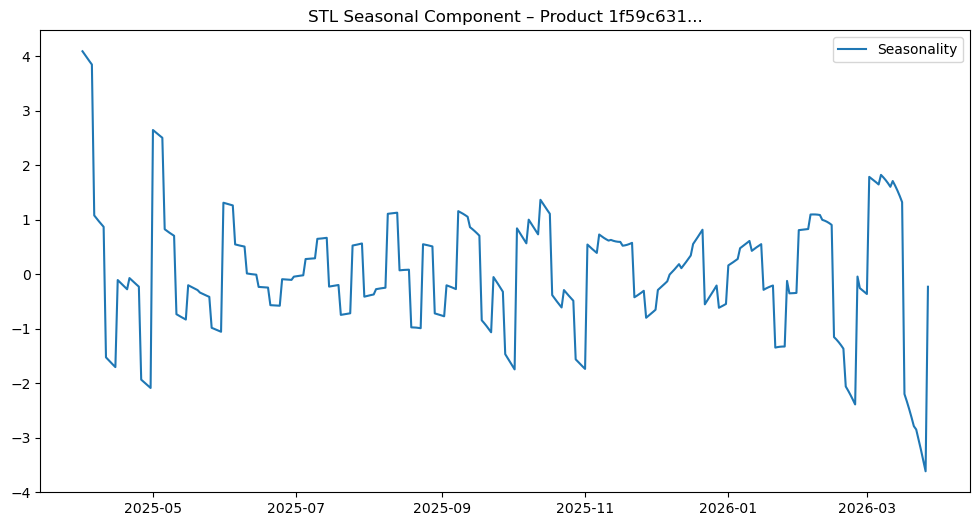

Saved STL plot → outputs/seasonality/stl_seasonality_plot.png
Saved seasonality stability → outputs/seasonality/seasonality_stability.csv


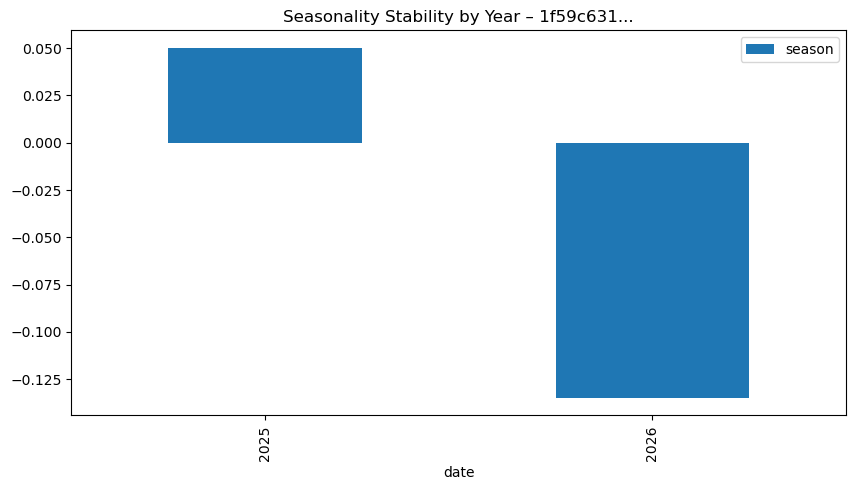

Saved seasonality stability plot → outputs/seasonality/seasonality_stability_plot.png


In [18]:
# -------------------------
#  STL Seasonality Stability
# -------------------------
stl_df = pd.DataFrame({
    "date": res.seasonal.index,
    "seasonal_component": res.seasonal.values
})
stl_df.to_csv("outputs/seasonality/stl_seasonal_component.csv", index=False)
print("Saved STL seasonal component → outputs/seasonality/stl_seasonal_component.csv")

plt.figure(figsize=(12,6))
plt.plot(res.seasonal, label="Seasonality")
plt.title(f"STL Seasonal Component – Product {product[:8]}...")
plt.legend()
plt.savefig("outputs/seasonality/stl_seasonality_plot.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved STL plot → outputs/seasonality/stl_seasonality_plot.png")

# Seasonality stability by year
seasonality_df = res.seasonal.groupby(prod_df.index.year).mean().reset_index()
seasonality_df.to_csv("outputs/seasonality/seasonality_stability.csv", index=False)
print("Saved seasonality stability → outputs/seasonality/seasonality_stability.csv")

seasonality_df.set_index("date").plot(kind='bar', figsize=(10,5),
                                      title=f"Seasonality Stability by Year – {product[:8]}...")
plt.savefig("outputs/seasonality/seasonality_stability_plot.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved seasonality stability plot → outputs/seasonality/seasonality_stability_plot.png")

In [19]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import numpy as np

# --- Forecast Leaderboard ---

# Prepare test set (last 30 days)
test_window = 30
train_series = prod_df.iloc[:-test_window]
test_series = prod_df.iloc[-test_window:]

# 1. SARIMA predictions on test window
sarima_forecast_test = sarima_result.get_forecast(steps=test_window)
sarima_pred_test = sarima_forecast_test.predicted_mean

sarima_mae = mean_absolute_error(test_series, sarima_pred_test)
sarima_rmse = root_mean_squared_error(test_series, sarima_pred_test)

# 2. Holt-Winters predictions on test window
hw_model = ExponentialSmoothing(train_series, trend="add", seasonal="add", seasonal_periods=30)
hw_fit = hw_model.fit()
hw_pred_test = hw_fit.forecast(test_window)

hw_mae = mean_absolute_error(test_series, hw_pred_test)
hw_rmse = root_mean_squared_error(test_series, hw_pred_test)

# 3. Random Forest (already computed on last 30 days)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = root_mean_squared_error(y_test, rf_preds)

# --- Combine into leaderboard ---
leaderboard = pd.DataFrame({
    "Model": ["SARIMA", "Holt-Winters", "Random Forest"],
    "MAE": [sarima_mae, hw_mae, rf_mae],
    "RMSE": [sarima_rmse, hw_rmse, rf_rmse]
})

leaderboard.to_csv("outputs/forecasts/forecast_leaderboard.csv", index=False)
print("Saved forecast leaderboard → outputs/forecasts/forecast_leaderboard.csv")

display(leaderboard)

Saved forecast leaderboard → outputs/forecasts/forecast_leaderboard.csv


,Model,MAE,RMSE
0,SARIMA,4.802918,5.524540
1,Holt-Winters,7.150069,7.746832
2,Random Forest,1.056241,2.065374
